In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [80]:
fast = True

In [81]:
# pd.read_csv("/kaggle/input/playground-series-s6e2/sample_submission.csv").head(2)

In [82]:
train = pd.read_csv("kaggle/input/playground-series-s6e2/train.csv")
test = pd.read_csv("kaggle/input/playground-series-s6e2/test.csv")

In [83]:
train.head(2)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence


In [84]:
bool_feats = [feat for feat in test.select_dtypes('number') if test[feat].nunique()==2]

num_feats = [feat for feat in test.select_dtypes(include='number').columns.tolist()]
# num_feats = [feat for feat in num_feats if feat not in bool_feats]

cat_feats = test.select_dtypes(exclude='number').columns.tolist()

In [85]:
target = "Heart Disease"
train[target] = train[target].map({"Presence": 1, "Absence": 0})

### Distributions

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_num_distribution_grid(df, num_feats=num_feats, grouper=target, bins=50, ncols=3):
    """
    Plot histograms + boxplots for numerical features in a grid layout.
    Each feature gets two stacked subplots (hist + box) with boxplot 1/3 height of histplot.
    Both plots share the same x-axis.
    """
    df[target] = df[target].astype('category')
    nrows = int(np.ceil(len(num_feats) / ncols))

    fig = plt.figure(figsize=(ncols*6, nrows*4))
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols, hspace=0.6)

    for i, feat in enumerate(num_feats):
        row = i // ncols
        col = i % ncols

        # Sub-grid with height ratio 3:1 and shared x-axis
        sub_gs = gs[row, col].subgridspec(2, 1, height_ratios=[3, 1])
        ax_hist = fig.add_subplot(sub_gs[0])
        ax_box = fig.add_subplot(sub_gs[1], sharex=ax_hist)

        # Histogram
        # sns.histplot(data=df, x=feat, hue=grouper, bins=bins, kde=True,
        #              palette=palette, multiple="dodge", ax=ax_hist)
        sns.kdeplot(data=df, x=feat, hue=grouper, fill=True, ax=ax_hist)
        ax_hist.set_title(f"{feat} Distribution", fontsize=10, color='white', backgroundcolor='black')
        ax_hist.set_xlabel('')  # Remove x-label from histogram
        ax_hist.tick_params(axis='x', labelbottom=False)  # Hide x-ticks on histogram

        # Boxplot (horizontal to match x-axis)
        sns.boxplot(data=df, x=feat, y=grouper,
                    ax=ax_box,
                    flierprops=dict(marker='o', markerfacecolor='red',
                                    markeredgecolor='black', markersize=3))
        plt.ylabel('')

    plt.show()

In [87]:
if not fast:
    plot_num_distribution_grid(train)

# Feature Engineering

In [88]:
train.head(2)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0


In [89]:
for df in (test, train):
    df["high_bp"] = (df["BP"] >= 140).astype(int)
    df["high_chol"] = (df["Cholesterol"] >= 240).astype(int)
    df["high_risk_count"] = df["high_bp"] + df["high_chol"] + df["FBS over 120"]

    df["ST_pos"] = (df["ST depression"] > 0).astype(int)
    
    df["MaxHR_pred"] = 220 - df["Age"]
    df["HR_ratio"] = df["Max HR"] / df["MaxHR_pred"].replace(0, np.nan)
    df["HR_deficit"] = df["MaxHR_pred"] - df["Max HR"]

    df["vessels_any"] = (df["Number of vessels fluro"] > 0).astype(int)
    df["vessels_2plus"] = (df["Number of vessels fluro"] >= 2).astype(int)

    # Chest pain + thallium flags
    df["cp_asymptomatic"] = (df["Chest pain type"] == 4).astype(int)
    df["thal_normal"] = (df["Thallium"] == 3).astype(int)
    df["thal_fixed"] = (df["Thallium"] == 6).astype(int)
    df["thal_reversible"] = (df["Thallium"] == 7).astype(int)

    # A couple interactions
    df["exang_x_st"] = df["Exercise angina"] * df["ST depression"]
    df["vessels_x_thal"] = df["Number of vessels fluro"] * df["Thallium"]

    # Bool feature from exang_x_st, a 1 in this feature is a very likely indicator of heart disease
    df["exang_x_st_bool"] = (df["exang_x_st"] > 0).astype(int)

    train[train[target] == 1]["Age"].median()

    # Age over median of positive cases
    df["age_over_median"] = (df["Age"] > (train[train[target] == 1]["Age"].median())).astype(int)
    # Chest pain 4
    df["chest_pain_4"] = (df["Chest pain type"] == 4).astype(int)

In [90]:
bool_feats = [feat for feat in test.select_dtypes('number') if test[feat].nunique()==2]

num_feats = [feat for feat in test.select_dtypes(include='number').columns.tolist()]
# num_feats = [feat for feat in num_feats if feat not in bool_feats]

cat_feats = test.select_dtypes(exclude='number').columns.tolist()

In [91]:
if not fast:
    plot_num_distribution_grid(train, num_feats=num_feats)

In [92]:
feature = "exang_x_st"
experiment = train[[feature, target]].copy()
experiment = experiment[experiment[feature] > 0][[feature, target]]
experiment.shape

(119295, 2)

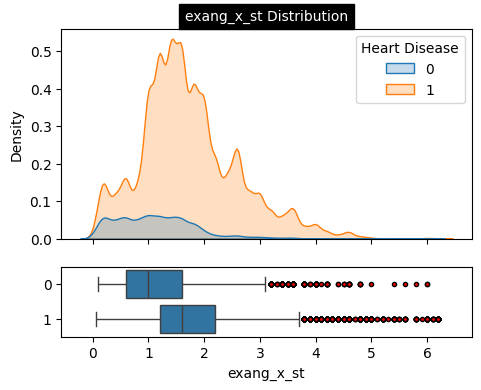

In [93]:
plot_num_distribution_grid(experiment, num_feats=[feature])

# Training

try:
- NN, Linear regression, CatBoost?
- Find original formula of DL model used to generate comp data?
- Statistical features?
- Ensemble techniques?
- Check forums

In [94]:
X = train.drop(columns=[target, "id"])
y = train[target].values
X_test = test.drop("id", axis=1)

# Cross-Validation Setup (Kfold)

In [97]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb

In [99]:
s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Query shuffle??

# OOF predictions
oof_lgb = np.zeros(len(X))
oof_xgb = np.zeros(len(X))

# Test predictions
test_lgb = np.zeros(len(X_test))
test_xgb = np.zeros(len(X_test))

# Train + Run

In [106]:
# LightGBM (GPU)
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.02,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    # "device": "gpu",
    # "gpu_use_dp": False,
    "verbosity": -1,
    "seed": 42
}

# XGBoost (CPU)
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.02,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "predictor": "auto",
    "seed": 42
}

In [110]:
for fold, (train_idx, val_idx) in enumerate(s_kfold.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")

    # Split data
    X_tr_lgb, X_val_lgb = X.iloc[train_idx], X.iloc[val_idx]
    X_tr_xgb, X_val_xgb = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # ---------- LightGBM ----------
    lgb_train = lgb.Dataset(X_tr_lgb, y_tr)
    lgb_val   = lgb.Dataset(X_val_lgb, y_val, reference=lgb_train)

    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_val],
        callbacks=[lgb.early_stopping(300)]
    )

    oof_lgb[val_idx] = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
    test_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration) / 5

    # ---------- XGBoost ----------
    dtrain = xgb.DMatrix(X_tr_xgb, label=y_tr)
    dval   = xgb.DMatrix(X_val_xgb, label=y_val)
    dtest  = xgb.DMatrix(X_test)

    xgb_model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dval, "val")],
        early_stopping_rounds=300,
        verbose_eval=False
    )

    oof_xgb[val_idx] = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration))
    test_xgb += xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration)) / 5


===== Fold 1 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[650]	valid_0's auc: 0.955252


c:\projects\kaggle-predicting-heart-disease\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:28:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()



===== Fold 2 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[655]	valid_0's auc: 0.954299


c:\projects\kaggle-predicting-heart-disease\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:30:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()



===== Fold 3 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[614]	valid_0's auc: 0.955137


c:\projects\kaggle-predicting-heart-disease\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:31:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()



===== Fold 4 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[590]	valid_0's auc: 0.954546


c:\projects\kaggle-predicting-heart-disease\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:33:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()



===== Fold 5 =====
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[697]	valid_0's auc: 0.955472


c:\projects\kaggle-predicting-heart-disease\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [111]:
print("LightGBM CV AUC:", roc_auc_score(y, oof_lgb))
print("XGBoost CV AUC:", roc_auc_score(y, oof_xgb))

LightGBM CV AUC: 0.9549384988121098
XGBoost CV AUC: 0.9549448200234302


In [113]:
oof_ensemble = 0.5 * oof_lgb + 0.5 * oof_xgb
test_ensemble = 0.5 * test_lgb + 0.5 * test_xgb
print("Ensemble CV AUC:", roc_auc_score(y, oof_ensemble))

Ensemble CV AUC: 0.955000557722786


In [ ]:
submission = pd.DataFrame({
    "id": test["id"],
    target": test_ensemble
})

In [117]:
submission[target] = submission[target].clip(lower=0, upper=1)

In [118]:
submission.to_csv("sumbission.csv", index=False)

# Ensemble

What technique to use?